# Scoring segmentation

Load previously segmented images and compare them to a ground truth

In [25]:
import napari
import cellpose
from octopuslite import utils, tile
import numpy as np

import sys
sys.path.append('../macrohet/')
from notify import send_sms

from skimage.io import imread, imsave
from skimage.morphology import remove_small_objects, remove_small_holes, binary_erosion, square

import napari 

def view(img):
    return napari.Viewer().add_image(img)

import umetrics

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = utils.read_harmony_metadata(metadata_fn)

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
utils.read_harmony_metadata(metadata_path, assay_layout=True)

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Define row and column of choice

In [4]:
row = '6'
column = '9'

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [5]:
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, 
                             column, 
#                              set_channel=1, 
                             set_plane = 'sum_proj',
#                              set_time = 1
                         )#.astype(uint8)
images

dask.array<sum-aggregate, shape=(75, 2, 6048, 6048), dtype=uint64, chunksize=(1, 2, 2016, 2016), chunktype=numpy.ndarray>

# Load model-segmented masks 

In [6]:
masks_dict = np.load('/mnt/DATA/macrohet/segmentation/[6,9]_modified_mask_dict.npy', allow_pickle=True).item()

In [7]:
masks_dict

{(200,
  0.0): dask.array<stack, shape=(75, 6048, 6048), dtype=uint8, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (200,
  0.6): dask.array<stack, shape=(75, 6048, 6048), dtype=uint8, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (250,
  0.0): dask.array<stack, shape=(75, 6048, 6048), dtype=uint8, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (300,
  0.0): dask.array<stack, shape=(75, 6048, 6048), dtype=uint8, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (300,
  0.6): dask.array<stack, shape=(75, 6048, 6048), dtype=uint8, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>,
 (200,
  0.8): dask.array<stack, shape=(75, 6048, 6048), dtype=uint8, chunksize=(1, 6048, 6048), chunktype=numpy.ndarray>}

In [8]:
masks_dict.keys()

dict_keys([(200, 0.0), (200, 0.6), (250, 0.0), (300, 0.0), (300, 0.6), (200, 0.8)])

# checking to see if what i think they are 

In [22]:
masks = masks_dict[(200,0.0)]

In [26]:
v = napari.Viewer()
v.add_image(images[0,0,...], colormap='green', contrast_limits=(100,6000))
for key in masks_dict.keys():
    v.add_labels(masks_dict[key][0], name = key)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


# Designate GT vs predicted 

In [12]:
true = imread('/mnt/DATA/macrohet/segmentation/ground_truth/semantic_r06c09f0*p*1-ch1sk1fk1fl1.tiff')

In [52]:
true = np.zeros(true_inst.shape, dtype = np.uint8)
for segment_ID in tqdm(range(1, np.max(true_inst))):
    segment = true_inst == segment_ID 
    eroded_segment = binary_erosion(segment)
    true += eroded_segment.astype(np.uint8)

  0%|          | 0/694 [00:00<?, ?it/s]

In [19]:
view(true_inst)

Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7f648e652640>

In [10]:
preds = list()
for key in masks_dict.keys():
    preds.append(masks_dict[key][0])
    

# Now check IoU and how many cells were actually changed

#### testing it works first

on instacne segm

In [13]:
true_crop = true[0:500, 0:500]
pred_crop = preds[0][0:500, 0:500].compute()

In [34]:
pred_crop_erode = binary_erosion(pred_crop, footprint=square(20))
true_crop_erode = binary_erosion(true_crop, footprint=square(20))

 Segmentation Metrics (n=1)
Strict: True (IoU > 0.01)
n_true_labels: 5
n_pred_labels: 4
n_true_positives: 3
n_false_positives: 1
n_false_negatives: 0
IoU: 0.919
Jaccard: 0.750
pixel_identity: 0.954
localization_error: 33.152



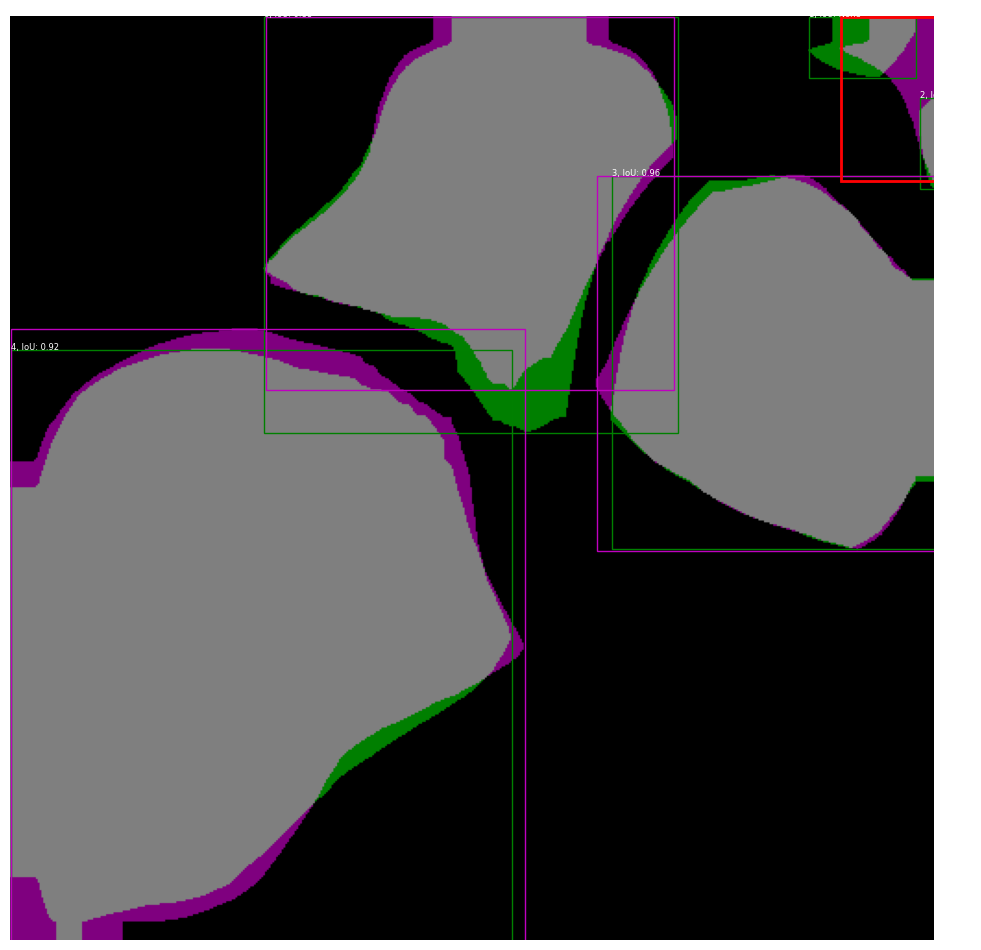

In [38]:
results = umetrics.calculate(true_crop_erode, pred_crop_erode, strict = True, iou_threshold = 0.01)
print(results.results)
results.plot()

# Seems like the issue might be the width between segments?

In [39]:
pred_erode = binary_erosion(preds[0], footprint=square(20))
true_erode = binary_erosion(true, footprint=square(20))

 Segmentation Metrics (n=1)
Strict: True (IoU > 0.1)
n_true_labels: 28
n_pred_labels: 27
n_true_positives: 17
n_false_positives: 9
n_false_negatives: 3
IoU: 0.874
Jaccard: 0.586
pixel_identity: 0.926
localization_error: 96.853



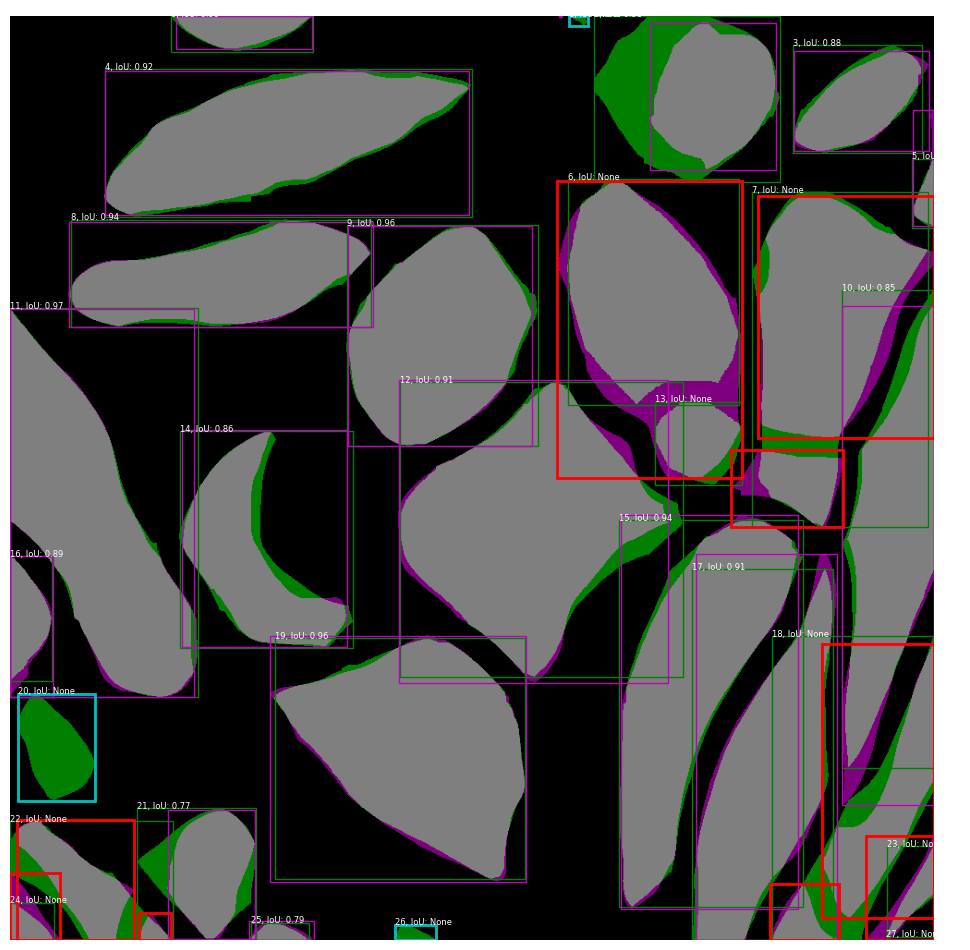

In [42]:
results = umetrics.calculate(true_erode[1000:2000, 1000:2000], 
                             pred_erode[1000:2000, 1000:2000], 
                             strict = True, iou_threshold = 0.1)
print(results.results)
results.plot()

# Whole image

 Segmentation Metrics (n=1)
Strict: True (IoU > 0.5)
n_true_labels: 653
n_pred_labels: 620
n_true_positives: 402
n_false_positives: 205
n_false_negatives: 59
IoU: 0.877
Jaccard: 0.604
pixel_identity: 0.927
localization_error: 70.955



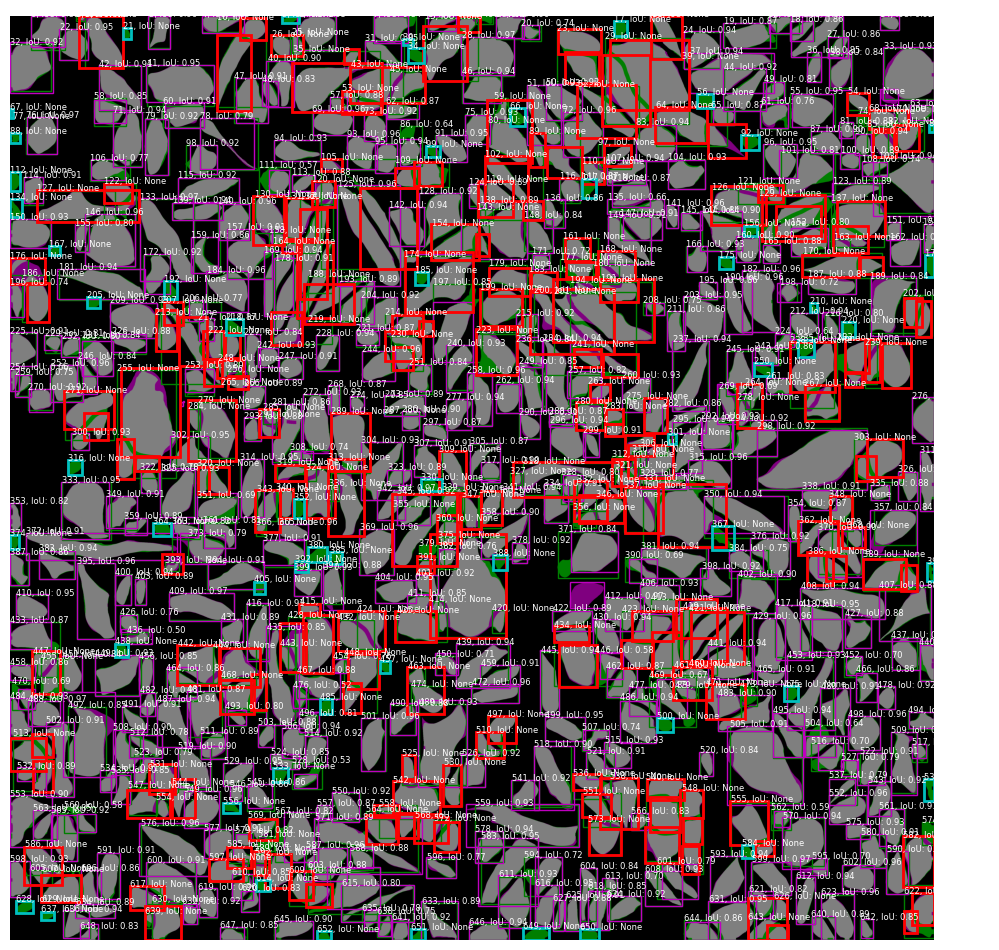

In [43]:
results = umetrics.calculate(true_erode,
                             pred_erode,
                             strict = True, iou_threshold = 0.5)
print(results.results)
results.plot()

 Segmentation Metrics (n=1)
Strict: True (IoU > 0.2)
n_true_labels: 653
n_pred_labels: 620
n_true_positives: 403
n_false_positives: 204
n_false_negatives: 59
IoU: 0.876
Jaccard: 0.605
pixel_identity: 0.927
localization_error: 71.555



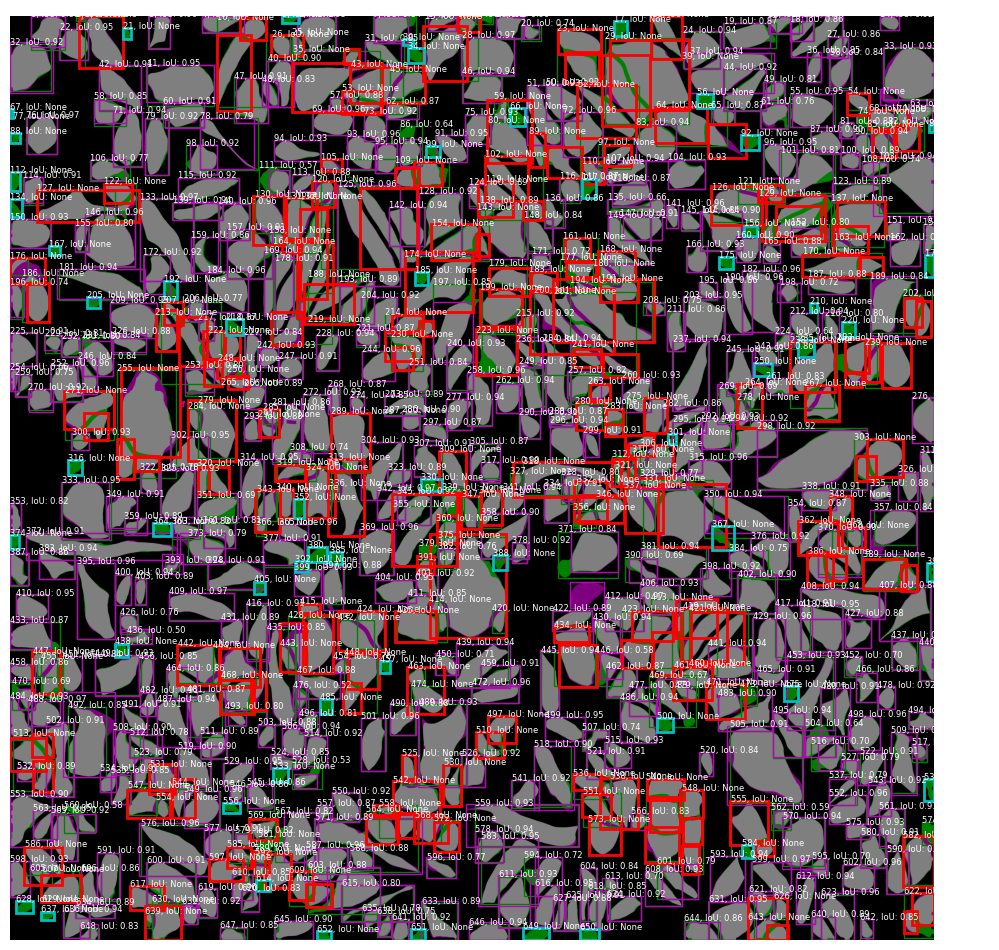

In [47]:
results = umetrics.calculate(true_erode,
                             pred_erode,
                             strict = True, iou_threshold = 0.2)
print(results.results)
results.plot()

# !Save out results

In [257]:
true_erode = binary_erosion(remove_small_holes(true, area_threshold=50), square(10))
pred_erode = binary_erosion(remove_small_holes(pred, area_threshold=50), square(10))

 Segmentation Metrics (n=1)
n_true_labels: 27
n_pred_labels: 20
n_true_positives: 14
n_false_positives: 6
n_false_negatives: 5
IoU: 0.881
Jaccard: 0.560
pixel_identity: 0.890
localization_error: 25.463



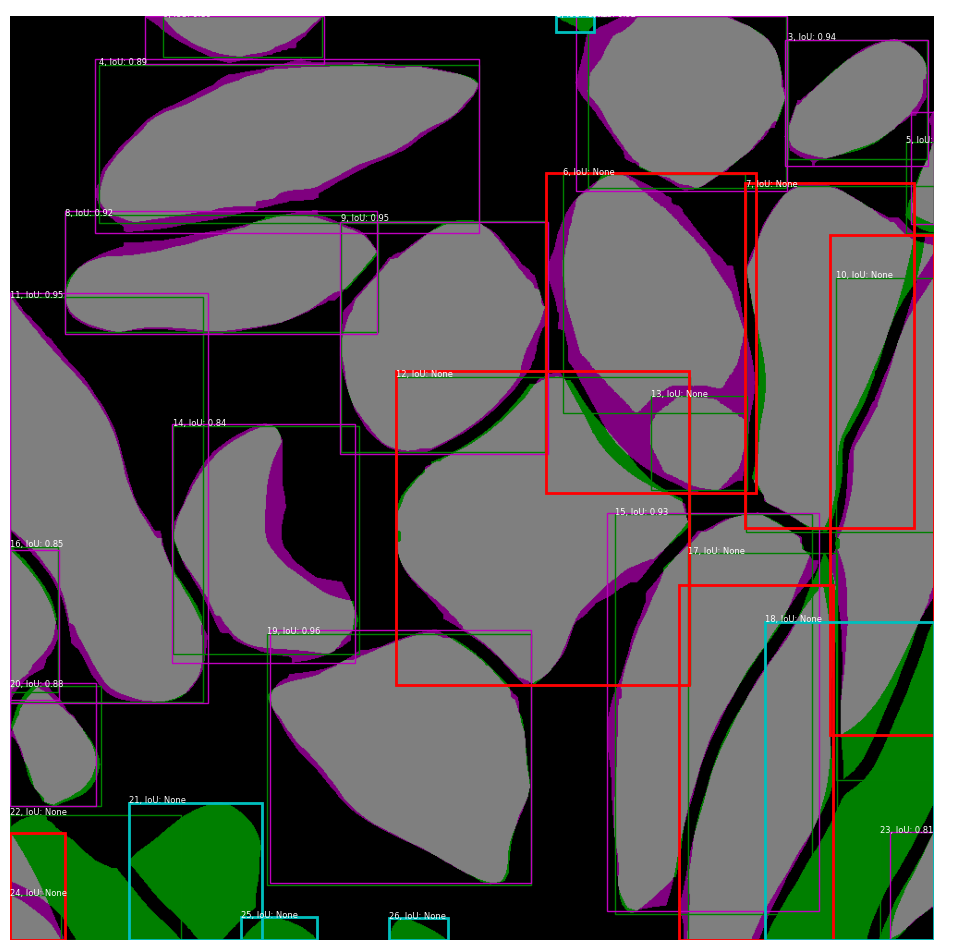

In [258]:
results = umetrics.calculate(true_erode[1000:2000, 1000:2000], pred_erode[1000:2000, 1000:2000])
print(results.results)
results.plot()

 Segmentation Metrics (n=1)
n_true_labels: 27
n_pred_labels: 27
n_true_positives: 9
n_false_positives: 18
n_false_negatives: 1
IoU: 0.837
Jaccard: 0.321
pixel_identity: 0.931
localization_error: 130.005



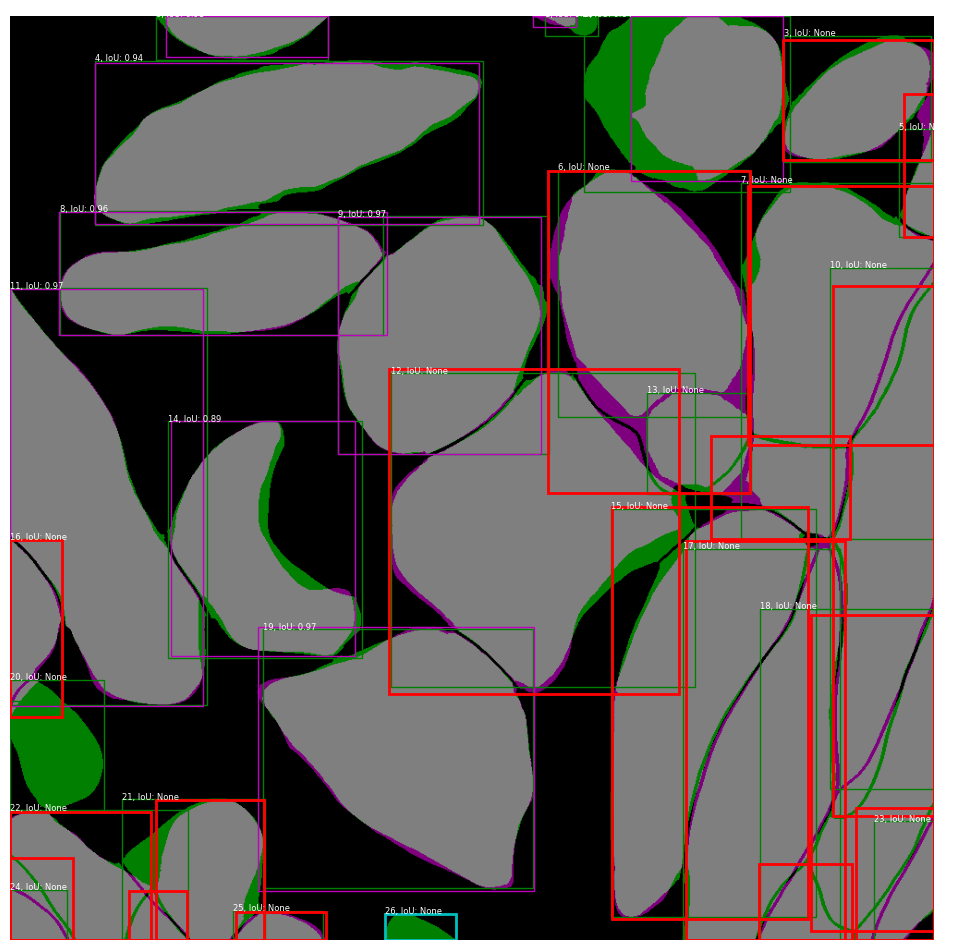

In [85]:
results = umetrics.calculate(true_erode[1000:2000, 1000:2000], pred_erode[1000:2000, 1000:2000])
print(results.results)
results.plot()

# Needs erosion to work

How many erosions until TP == 17?

In [101]:
true_erode = binary_erosion(true)
pred_erode = binary_erosion(pred)

In [130]:
true_erode = binary_erosion(true_erode)
pred_erode = binary_erosion(pred_erode)

 Segmentation Metrics (n=1)
n_true_labels: 27
n_pred_labels: 27
n_true_positives: 9
n_false_positives: 18
n_false_negatives: 1
IoU: 0.837
Jaccard: 0.321
pixel_identity: 0.931
localization_error: 130.005



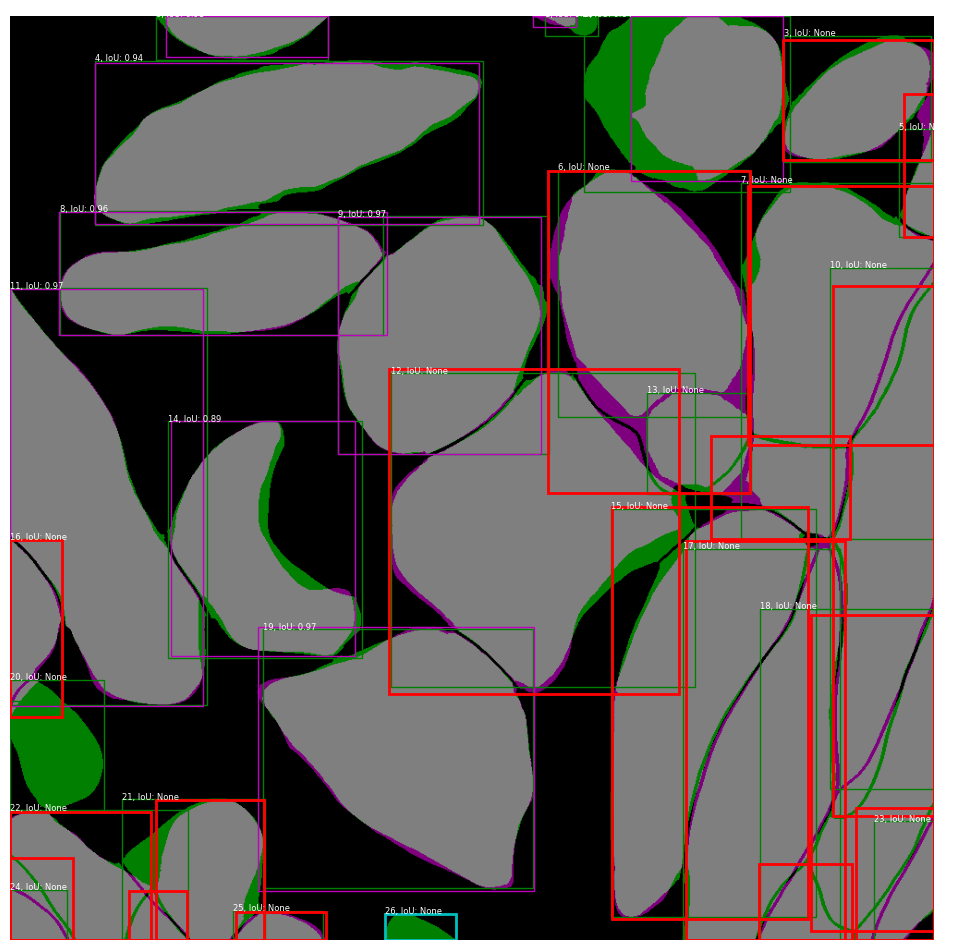

In [170]:
results = umetrics.calculate(true_erode[1000:2000, 1000:2000], pred_erode[1000:2000, 1000:2000],)
scores = results.results             
print(results.results)
results.plot()
plt.savefig('seg_score.tiff', bbox_inches = 'tight', dpi = 314)
plot = imread('seg_score.tiff')

In [105]:
view(plot)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7fc217f6c4c0>

# Whole image

 Segmentation Metrics (n=1)
n_true_labels: 652
n_pred_labels: 620
n_true_positives: 406
n_false_positives: 203
n_false_negatives: 61
IoU: 0.873
Jaccard: 0.606
pixel_identity: 0.928
localization_error: 72.082

CPU times: user 15min 3s, sys: 3min 40s, total: 18min 44s
Wall time: 18min 43s


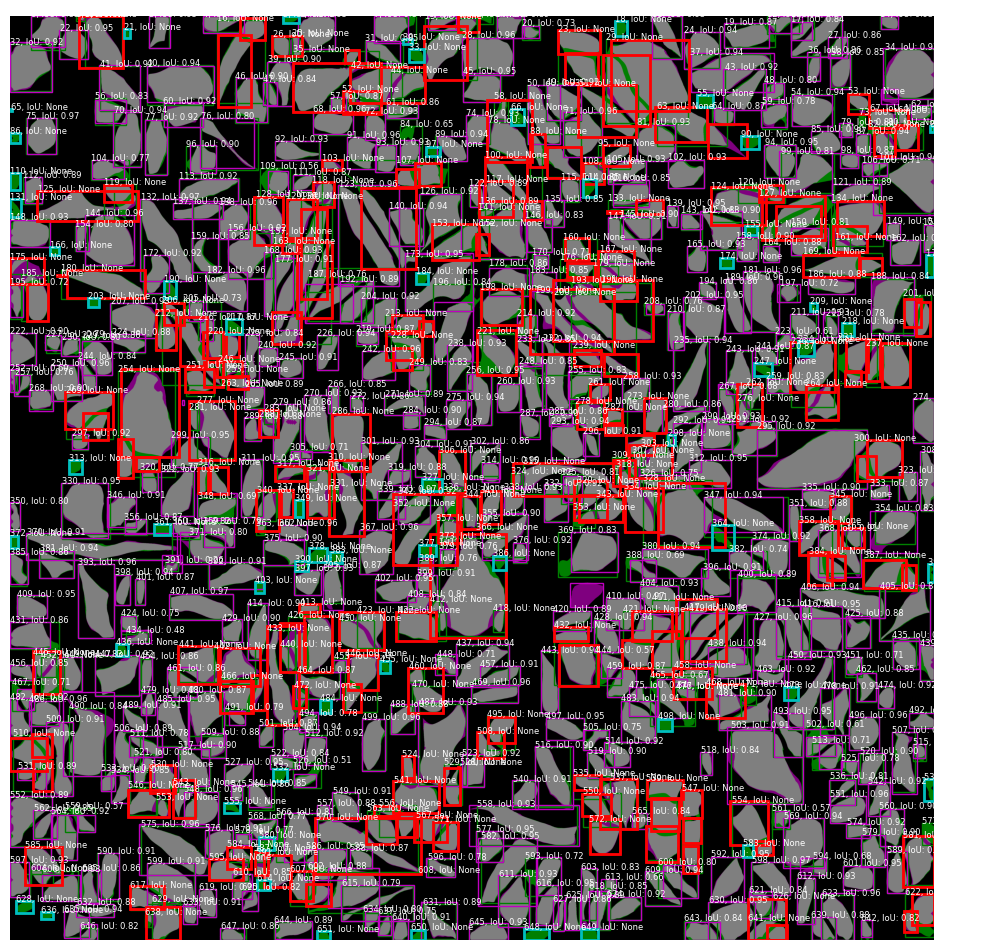

In [133]:
%%time
### apply 15 eroisions for a buffer of ten pixels
true_eroded = binary_erosion(true)
pred_eroded = binary_erosion(pred)
for i in range(14):
    true_eroded = binary_erosion(true_eroded)
    pred_eroded = binary_erosion(pred_eroded)
results = umetrics.calculate(true_eroded, pred_eroded)
print(results.results)
results.plot()
plt.savefig('seg_score.tiff', bbox_inches = 'tight', dpi = 314)
plot = imread('seg_score.tiff')

In [134]:
view(plot)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'img' at 0x7fc20d34c730>

In [136]:
v = napari.Viewer()
v.add_image(true, colormap='green', blending = 'additive')
v.add_image(pred, colormap='green', blending = 'additive')
v.add_image(plot)


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'plot' at 0x7fc2283f30d0>

In [140]:
v = napari.Viewer()
v.add_labels(true,)
for key in masks_dict.keys():
    v.add_labels(masks_dict[key][0], name = key)

v.add_image(images[0,0,...], colormap='green', blending = 'additive')


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'Image' at 0x7fc1cfa78a90>

Diameter seems to be the largest factor in deciding whether over or undersegmented. The automatic diameter decision is not good for these cells so I will now

# Testing different diameters

Load different model masks for different diameters (rest of settings default) and compile with 300 diam mask already calculated.

In [10]:
import glob, os
from skimage.io import imshow, imread

In [11]:
model_mask_dir = '/mnt/DATA/macrohet/segmentation/row6col9t1_model_seg'

In [12]:
### load model predicted mask images
preds = [(fn.split(':')[-1],imread(fn)) for fn in glob.glob(os.path.join(model_mask_dir, '*.tiff'))]  

In [13]:
preds

[('400.tiff',
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)),
 ('300.tiff',
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)),
 ('350.tiff',
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))]

In [ ]:
scores_df = pd.DataFrame({}, columns=['IoU', 
                                      'Jaccard', 
                                      'Localisation Error', 
                                      'Pixel ID', 'String'])
for diameter, pred in tqdm(preds):
    ### hole closing and erosion for umetrics
    true_eroded = binary_erosion(remove_small_holes(true, area_threshold=50), square(3))
    pred_eroded = binary_erosion(remove_small_holes(pred, area_threshold=50), square(3))
    results = umetrics.calculate(true_eroded, pred_eroded)
    scores = results.results
    scores_df.at[diameter, 'IoU'] = scores.IoU
    scores_df.at[diameter, 'Jaccard'] = scores.Jaccard
    scores_df.at[diameter, 'Localisation Error'] = scores.localization_error
    scores_df.at[diameter, 'Pixel ID'] = scores.pixel_identity
    scores_df.at[diameter, 'True Labels'] = int(re.compile('true_labels: ([0-9]*)').findall(str(scores))[0])
    scores_df.at[diameter, 'Predicted Labels'] = int(re.compile('pred_labels: ([0-9]*)').findall(str(scores))[0])
    scores_df.at[diameter, 'True Positives'] = int(re.compile('true_positives: ([0-9]*)').findall(str(scores))[0])
    scores_df.at[diameter, 'False Positives'] = int(re.compile('false_positives: ([0-9]*)').findall(str(scores))[0])
    scores_df.at[diameter, 'False Negatives'] = int(re.compile('false_negatives: ([0-9]*)').findall(str(scores))[0])                                                     
    
    output_fn = f'/mnt/DATA/macrohet/segmentation/segmentation_scores/row6col9t1_scores/diam:{diameter}_seg_score'
    scores_df.to_csv(f'{output_fn}.csv',)
    results.plot()
    plt.savefig(f'{output_fn}.tiff', 
                bbox_inches = 'tight', dpi = 314, 
                pad_inches=0)

  0%|          | 0/3 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/_shared/utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/_shared/utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/_shared/utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


# Assessing scores

In [16]:
import pandas as pd
import glob
import csv

In [28]:
scores_df = pd.read_csv('/mnt/DATA/macrohet/segmentation/segmentation_scores/row6col9t1_scores/scores.csv')
scores_df

Diameter       IoU   Jaccard  Localisation Error  Pixel ID  True Labels  \
0       400  0.883831  0.151961           39.496564  0.846460          649   
1       300  0.901176  0.227979           54.044996  0.930007          649   
2       350  0.914446  0.265306           30.142677  0.895512          649   

   Predicted Labels  True Positives  False Positives  False Negatives  
0               336              62              271               75  
1               556             132              422               25  
2               450             130              318               42

# FIXING BUG: 

Why isn't the Jaccard index higher?

In [38]:
true = true_inst
pred = preds[1][1]

In [44]:
v = napari.Viewer()
v.add_image(true)
v.add_image(pred)

Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'pred' at 0x7feb9c1a1a30>